In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import math


import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [4]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [5]:
# fill the nan values
data.fillna(data.median(), inplace=True)

sale_price = data['total_price'].values
data = data.drop('total_price', axis=1)

columns = data.columns
# check has any nan value in data
data.isnull().values.any()
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [6]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaling_data = x_scaler.fit_transform(data)
scaling_sale_price = y_scaler.fit_transform(sale_price.reshape(-1, 1))

data = pd.DataFrame(scaling_data, columns = columns)
sale_price = pd.DataFrame(sale_price, columns=['total_price'])
print(type(data))

<class 'pandas.core.frame.DataFrame'>


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
# split data
train_x = data.iloc[:60000]
test_x  = data.iloc[60000:]

train_y = sale_price.iloc[:60000]
test_y = sale_price.iloc[60000:]


In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

In [9]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(self.fc4(x))
        
        
        return x

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            torch.nn.init.zeros_(m.bias)

In [10]:
def batch_training(X_train, y_train):
    train_batch = np.array_split(X_train, 50)
    label_batch = np.array_split(y_train, 50)

    for i in range(len(train_batch)):
        train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
    for i in range(len(label_batch)):
        label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)
    return train_batch, label_batch

#train_batch = torch.from_numpy(X_train.values).float().to(device)
#label_batch = torch.from_numpy(y_train).float().view(-1, 1).to(device)
train_batch, label_batch = batch_training(X_train, y_train)

In [11]:
X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [12]:
model = Regressor().to(device)
ps = model(train_batch[0])

In [13]:

model = Regressor().to(device)
#model.apply(weights_init)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

epochs = 50000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #MSE(output, label_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        #loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
                
        train_loss += loss.item()
        
        
    if e%50 == 0:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
            #test_loss += torch.sqrt(criterion(predictions, y_val))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.8f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.8f}.. ".format(test_loss))
        


Epoch: 1/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 51/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 101/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 801/50000..  Training Loss: nan..  T

Epoch: 6751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 6801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 6851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 6901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 6951/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7001/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7051/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7101/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 7551/50000..  Tra

Epoch: 14951/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15001/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15051/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15101/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 15701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 1

Epoch: 21601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 21951/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22001/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22051/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22101/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 22351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 2

Epoch: 28251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 28951/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 29001/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 2

Epoch: 36151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 36901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 3

Epoch: 42801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 42851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 42901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 42951/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43001/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43051/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43101/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43151/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43201/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43251/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43301/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43351/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43401/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 43551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 4

Epoch: 49451/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49501/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49551/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49601/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49651/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49701/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49751/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49801/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49851/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49901/50000..  Training Loss: nan..  Test Loss: nan.. 
Epoch: 49951/50000..  Training Loss: nan..  Test Loss: nan.. 


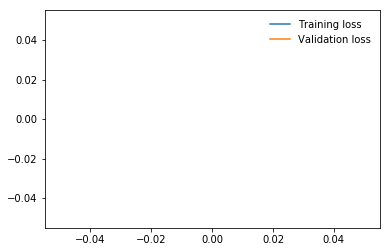

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# loss 0.24 -> 2800
# loss 0.14 -> 3300

In [15]:
test_x = torch.from_numpy(test_x.values).float().to(device)

In [16]:

with torch.no_grad():
    model.eval()
    output = model.forward(test_x)
    

output.shape
output = output.cpu().numpy()
#output_col = pd.DataFrame(test, columns = columns)

output = y_scaler.inverse_transform(output)


In [17]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output
submission.to_csv('submission/DNN_result.csv', index=False)